## Intro
ARIMA (AutoRegressive Integrated Moving Average) is a powerful time-series forecasting method that can be used not only to predict future values but also to detect anomalies by analyzing the residuals (the differences between actual and predicted values). It belongs to a class of models that explains a given time series based on its own past values -i.e.- its own lags and the lagged forecast errors. The equation can be used to forecast future values. Any ‘non-seasonal’ time series that exhibits patterns and is not a random white noise can be modeled with ARIMA models.

Predicted Yt = Constant + Linear combination Lags of Y (upto p lags) + Linear Combination of Lagged forecast errors (upto q lags)

## Types of ARIMA Model

`ARIMA` : Non-seasonal Autoregressive Integrated Moving Averages

`SARIMA` : Seasonal ARIMA

`SARIMAX` : Seasonal ARIMA with exogenous variables

If a time series, has seasonal patterns, then we need to add seasonal terms and it becomes SARIMA, short for Seasonal ARIMA.

## 1. Import Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

## 2. Data

In [412]:
dataset = pd.read_csv('./data/arima.txt')

In [414]:
dataset.head()

,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


## 3. Preprocess Data

In [416]:
dataset['value'].isnull().sum()

0

In [418]:
dataset['date'] = pd.to_datetime(dataset['date'])

In [420]:
# dataset.set_index('date',inplace=True)

In [422]:
dataset.head(3)

,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221


## 4. Check for Stationarity

ARIMA models require the time series to be stationary. We'll use the Augmented Dickey-Fuller (ADF) test to check for stationarity.

Differencing to Achieve Stationarity: If the series is non-stationary, apply differencing.

The purpose of differencing is to make the time series stationary. But we should be careful to not over-difference the series. An over differenced series may still be stationary, which in turn will affect the model parameters.

So we should determine the right order of differencing. The right order of differencing is the minimum differencing required to get a near-stationary series which roams around a defined mean and the ACF plot reaches to zero fairly quick.

If the autocorrelations are positive for many number of lags (10 or more), then the series needs further differencing. On the other hand, if the lag 1 autocorrelation itself is too negative, then the series is probably over-differenced.

If we can’t really decide between two orders of differencing, then we go with the order that gives the least standard deviation in the differenced series.

In [426]:
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Statistic', 'p-value', '# Lags Used', '# Observations']
    for value, label in zip(result, labels):
        print(f'{label}: {value}')
    if result[1] <= 0.05:
        print("=> The series is stationary.")
    else:
        print("=> The series is non-stationary.")

adf_test(dataset.value, title='Values')

Augmented Dickey-Fuller Test: Values
ADF Statistic: 3.145185689306742
p-value: 1.0
# Lags Used: 15
# Observations: 188
=> The series is non-stationary.


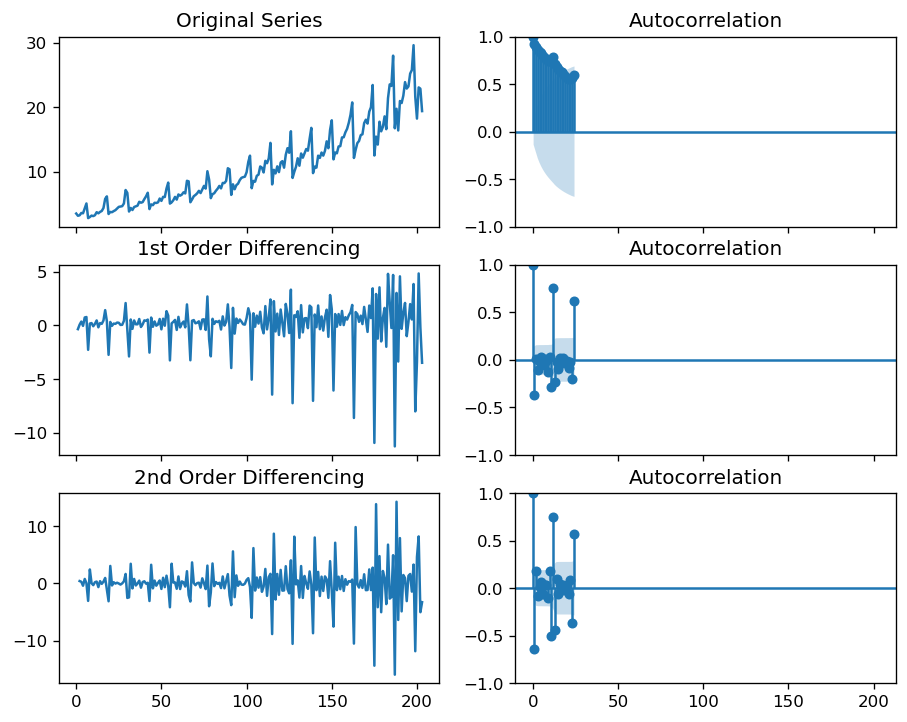

In [432]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(dataset.value); axes[0, 0].set_title('Original Series')
plot_acf(dataset.value, ax=axes[0, 1])

axes[1, 0].plot(dataset.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(dataset.value.diff().dropna(), ax=axes[1, 1])

axes[2, 0].plot(dataset.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(dataset.value.diff().diff().dropna(), ax=axes[2, 1])
plt.show()

#### Comments: 

we can see that the time series reaches stationarity with two orders of differencing

## 5. Determine ARIMA Parameters

### 5.1. ACF and PACF

`p` is the order of the Auto Regressive (AR) term. It refers to the number of lags of Y to be used as predictors.

The value of `d`, therefore, is the minimum number of differencing needed to make the series stationary. If the time series is already stationary, then d = 0.

`q` is the order of the Moving Average (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA Model.

Interpreting ACF and PACF:

* ACF (AutoCorrelation Function): Helps in identifying the MA (q) component.
* PACF (Partial AutoCorrelation Function): Helps in identifying the AR (p) component.

Rules of Thumb:

* If the ACF plot shows a sharp cutoff after lag q and the PACF decays slowly, consider an MA model.
* If the PACF plot shows a sharp cutoff after lag p and the ACF decays slowly, consider an AR model.
* If both ACF and PACF decay slowly, consider an ARMA model.

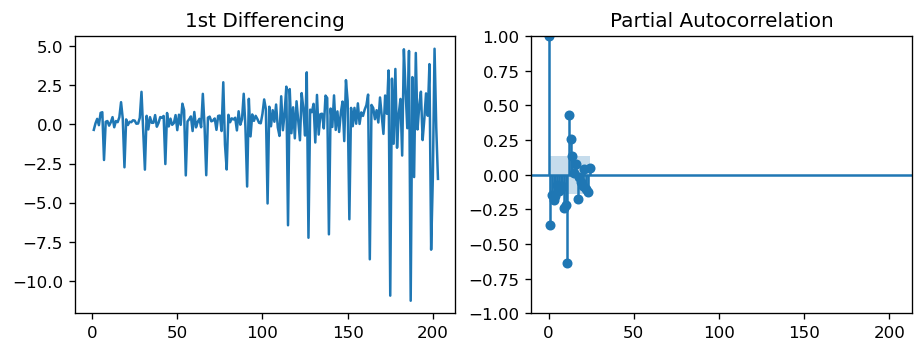

In [441]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(dataset.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(dataset.value.diff().dropna(), ax=axes[1])

plt.show()

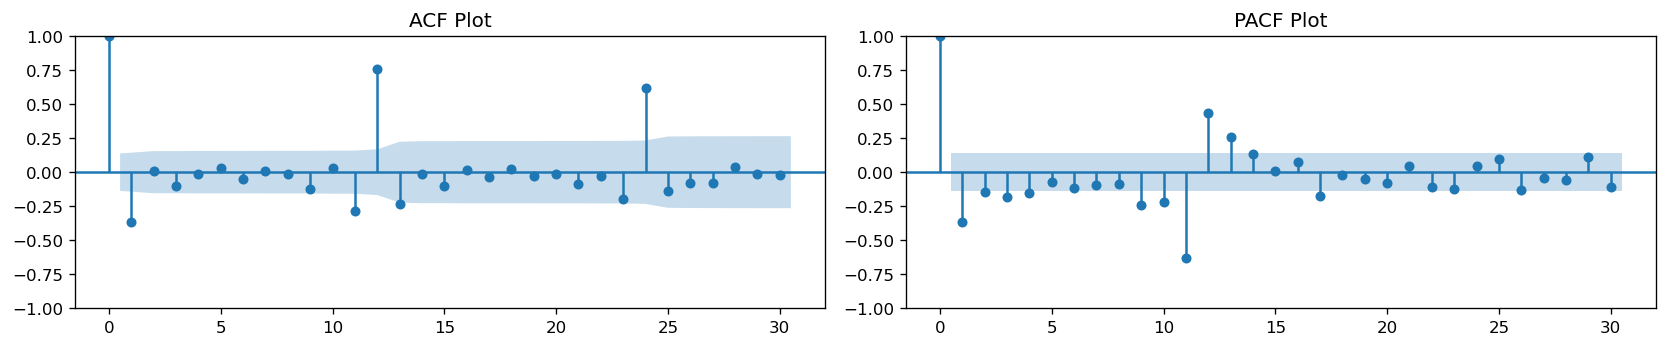

In [600]:
plt.figure(figsize=(14,3))

plt.subplot(121)
plot_acf(dataset.value.diff().dropna(), lags=30, ax=plt.gca())
plt.title('ACF Plot')

plt.subplot(122)
plot_pacf(dataset.value.diff().dropna(), lags=30, ax=plt.gca())
plt.title('PACF Plot')

plt.tight_layout()
plt.show()

# PACF lag 1 is quite significant
# couple of lags (ACF plot) are well above the significance line. So, we will fix q as 3

## 6. Fit the ARIMA Model

### 6.1. Manual Selection

In [646]:
# dataset_diff = dataset_diff.asfreq('D')
train_size = int(len(dataset) * 0.5)
train, test = dataset[:train_size], dataset[train_size:]

In [676]:
model = ARIMA(dataset.value, order=(2, 2, 3))
model_fit = model.fit()
print(model_fit.summary())

C:\Users\druzh\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  204
Model:                 ARIMA(2, 2, 3)   Log Likelihood                -410.737
Date:                Fri, 20 Sep 2024   AIC                            833.473
Time:                        17:50:04   BIC                            853.323
Sample:                             0   HQIC                           841.505
                                - 204                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6182      0.062     -9.953      0.000      -0.740      -0.496
ar.L2          0.3785      0.049      7.768      0.000       0.283       0.474
ma.L1         -1.0123      1.118     -0.905      0.3

In [724]:
model = ARIMA(dataset.value, order=(2,2,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  204
Model:                 ARIMA(2, 2, 1)   Log Likelihood                -435.944
Date:                Fri, 20 Sep 2024   AIC                            879.888
Time:                        17:57:40   BIC                            893.121
Sample:                             0   HQIC                           885.242
                                - 204                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4198      0.060     -6.957      0.000      -0.538      -0.302
ar.L2         -0.1462      0.071     -2.057      0.040      -0.286      -0.007
ma.L1         -0.9999      1.856     -0.539      0.5

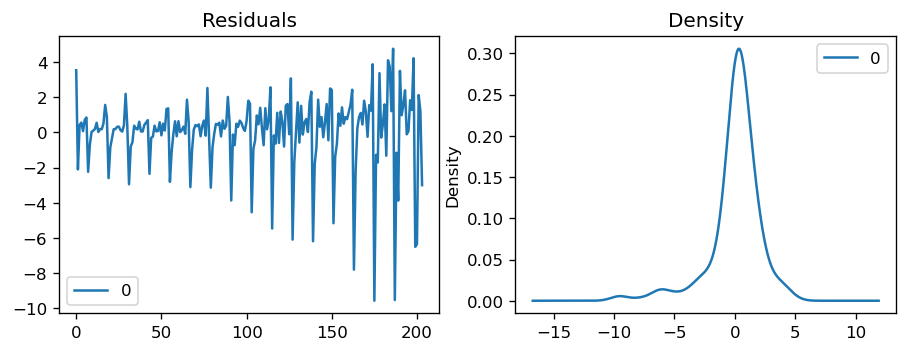

In [726]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()
# near zero mean and uniform variance

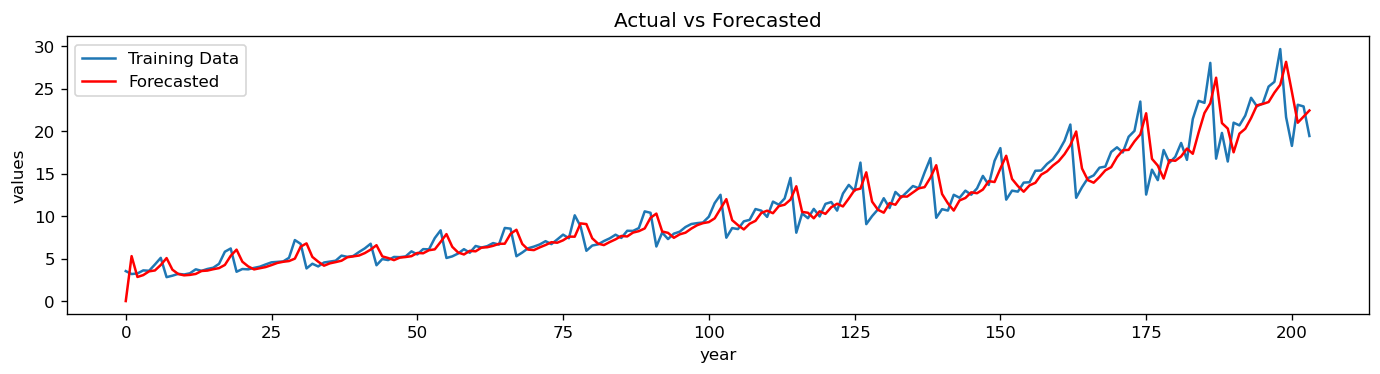

In [728]:
plt.figure(figsize=(14,3))
plt.plot(dataset.index, dataset.value, label='Training Data')
plt.plot(model_fit.predict().index, model_fit.predict(), label='Forecasted', color='red')
plt.legend()
plt.title('Actual vs Forecasted')
plt.xlabel('year')
plt.ylabel('values')
plt.show()

## 7. Out-of-Time Cross validation

Out-of-Time Cross Validation (OOTCV) is a technique used to evaluate the performance of a model, specifically for time series data. It differs from regular cross-validation because, in time series problems, data points are sequential and have an inherent temporal order. You can't randomly shuffle the data because that would break the time dependency.

OOTCV ensures that training and testing data are separated chronologically, allowing you to validate how well the model generalizes to unseen future data. This is particularly useful when working with forecasting or predictive models in scenarios where the time aspect is crucial (e.g., stock prices, energy consumption, etc.).

OOTCV splits the data into multiple consecutive time-based folds. Each fold uses a portion of the data as the training set, and a portion further along in time as the test set.

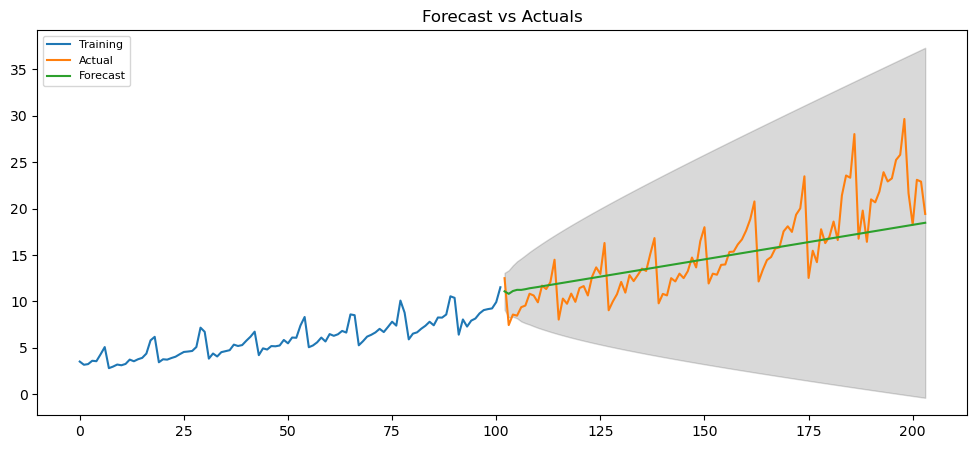

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  102
Model:                 ARIMA(2, 2, 1)   Log Likelihood                -145.718
Date:                Fri, 20 Sep 2024   AIC                            299.436
Time:                        17:57:52   BIC                            309.857
Sample:                             0   HQIC                           303.654
                                - 102                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2179      0.171     -1.274      0.203      -0.553       0.117
ar.L2         -0.2991      0.118     -2.525      0.012      -0.531      -0.067
ma.L1         -0.9995      4.520     -0.221      0.8

In [730]:
# Forecast
model = ARIMA(train.value, order=(2, 2, 1))
fitted = model.fit()

fc = fitted.get_forecast(steps=len(test))
fc_series = fc.predicted_mean
conf = fc.conf_int()

lower_series = conf.iloc[:, 0]
upper_series = conf.iloc[:, 1]

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.value, label='Training')
plt.plot(test.value, label='Actual')
plt.plot(fc_series, label='Forecast')
plt.fill_between(fc_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()
print(fitted.summary())

In [732]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test.value, fc_series)
mse = mean_squared_error(test.value, fc_series)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test.value - fc_series) / test.value)) * 100

print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.3f}%")

Mean Absolute Error (MAE): 2.382
Mean Squared Error (MSE): 10.365
Root Mean Squared Error (RMSE): 3.219
Mean Absolute Percentage Error (MAPE): 15.122%


### Interpretation:

MAE (2.382) and RMSE (3.219) suggest that the model has reasonably low error on average, but RMSE is a bit higher, indicating the presence of some larger errors or deviations in the forecast.

MSE (10.365) reinforces this by showing that larger errors have been squared and contribute more significantly to the error metric.

MAPE (15.122%) suggests that, on average, the model's predictions are 15.122% off from the actual values. This is moderate accuracy but could be improved for more precise forecasting.

## 8. Auto Arima Forecasting

You can use the `pmdarima` library to automatically select the best parameters.

Automated selection can save time and potentially find a better model, especially for complex datasets.

In [739]:
import pmdarima as pm

model = pm.auto_arima(dataset.value, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=874.416, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1602.665, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=913.571, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1392.713, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=865.809, Time=0.22 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=867.147, Time=0.31 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=871.437, Time=0.36 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=868.483, Time=0.16 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=858.292, Time=0.31 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=0.44 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=859.374, Time=0.35 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=860.819, Time=0.43 sec

Best model:  ARIMA(3,0,2)(0,0,0)[0]          
Total fit 

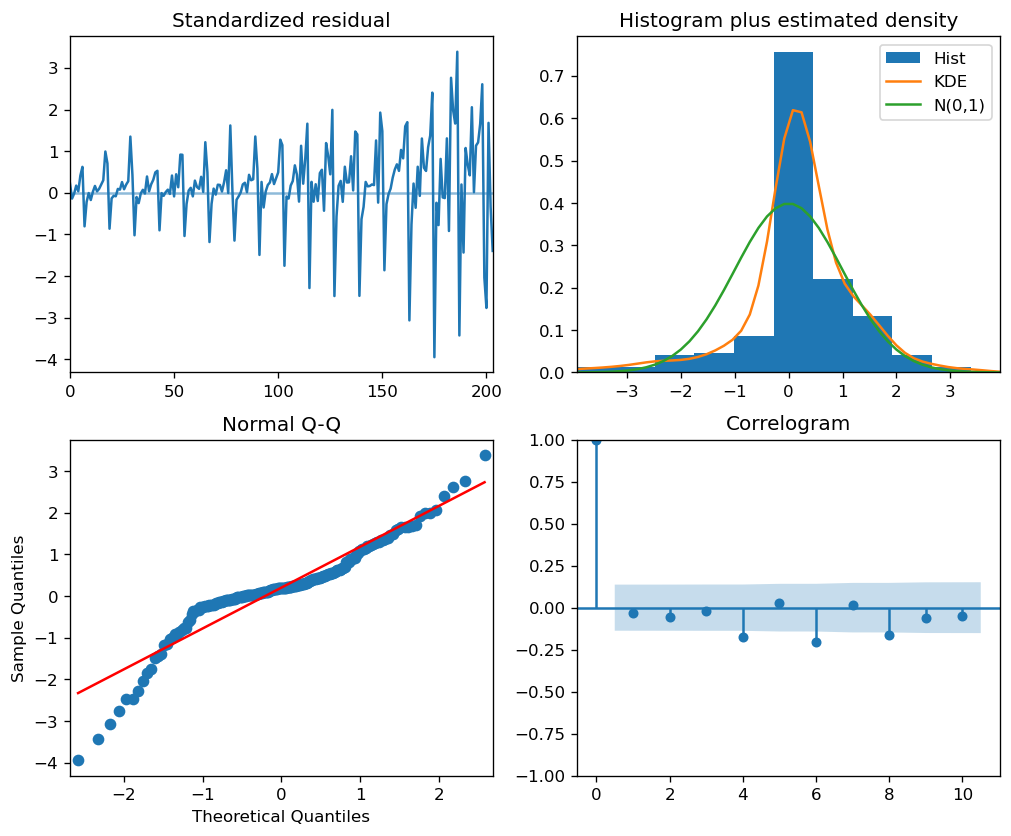

In [741]:
model.plot_diagnostics(figsize=(10,8))
plt.show()

### ARIMA Model Diagnostics Interpretation

The `plot_diagnostics()` function in `statsmodels` provides several key plots that help evaluate the goodness of fit for an ARIMA model. Here's a breakdown of each plot and how to interpret it:

---

    1. Standardized Residuals Plot (Top Left)

- **What it Shows**: This plot displays the standardized residuals over time. Standardized residuals are the residuals divided by their standard deviation, which makes it easier to see whether the residuals deviate from expected values.
  
- **How to Interpret**:
    - The residuals should appear as random noise around zero with no clear patterns.
    - If you observe trends, cycles, or volatility clustering (i.e., periods of larger and smaller variability), it suggests that the ARIMA model hasn't fully captured the underlying patterns in the data.
    - Large spikes or outliers in the residuals may indicate that the model is underperforming at certain time points.

---

    2. Histogram plus KDE (Top Right)

- **What it Shows**: This plot shows a histogram of the residuals overlaid with a Kernel Density Estimate (KDE), which provides a smoothed approximation of the residual distribution. A red line representing the normal distribution is also overlaid.
  
- **How to Interpret**:
    - Ideally, the histogram and KDE should resemble the red line, indicating that the residuals are approximately normally distributed.
    - Deviations from normality (e.g., skewness, heavy tails, or a multimodal distribution) suggest that the model may not be a good fit, especially if the residuals are far from normal.
    - In ARIMA models, residuals that are approximately normally distributed ensure better predictive performance and more accurate confidence intervals.

---

    3. Normal Q-Q Plot (Bottom Left)

- **What it Shows**: This plot compares the quantiles of the residuals against the theoretical quantiles of a normal distribution. If the residuals are normally distributed, the points should fall approximately along the 45-degree red line.
  
- **How to Interpret**:
    - Points close to the red line indicate that the residuals are approximately normally distributed.
    - Points deviating from the line, especially at the tails, suggest non-normality. For example:
        - Points above the line at the top right indicate heavy positive tails (too many large positive residuals).
        - Points below the line at the bottom left indicate heavy negative tails (too many large negative residuals).
    - Significant deviations from the line suggest that the model's error distribution is not normal, which could affect prediction accuracy and confidence intervals.

---

    4. Correlogram (ACF Plot of Residuals, Bottom Right)

- **What it Shows**: This plot shows the autocorrelation function (ACF) of the residuals at different lags. It checks whether the residuals are uncorrelated (i.e., whether any information from previous time steps has been left unexplained by the model).
  
- **How to Interpret**:
    - Ideally, all autocorrelation bars should lie within the blue dashed confidence intervals, indicating that the residuals are not autocorrelated and the model has captured the time-series structure.
    - Significant autocorrelation (bars outside the blue region) at any lag suggests that there’s still information in the residuals that the model has not captured. This may indicate the need to adjust the ARIMA order (`p`, `d`, `q`) or include other factors.


## 9. SARIMA model

If there’s any seasonality in data, you might need to use SARIMA (Seasonal ARIMA) instead of ARIMA to capture these patterns.

SARIMA is useful when your time series data has both seasonality and non-seasonal trends.

Seasonal differencing is similar to regular differencing, but, instead of subtracting consecutive terms, we subtract the value from previous season.

    SARIMA Model Parameters

1. Non-Seasonal Parameters (p, d, q):
These parameters are the same as in the standard ARIMA model:

- **p**: The number of **autoregressive (AR)** terms. This refers to the number of lagged values of the dependent variable that are used as predictors.
- **d**: The number of differences required to make the time series **stationary**. This is also known as the **degree of differencing**.
- **q**: The number of **moving average (MA)** terms. This refers to the number of lagged forecast errors used to adjust the model.

---

2. Seasonal Parameters (P, D, Q):
These are the seasonal counterparts of the ARIMA parameters:

- **P**: The number of **seasonal autoregressive (SAR)** terms. These are lagged seasonal values of the dependent variable.
- **D**: The number of **seasonal differences**, applied at the seasonal frequency to remove seasonality.
- **Q**: The number of **seasonal moving average (SMA)** terms. These adjust the model based on past forecast errors at the seasonal level.

---

3. Seasonal Period (m):
- **m**: The number of time steps per season. This defines the length of the seasonal cycle.
  - For example:
    - **m = 12** for monthly data with yearly seasonality (12 months per year).
    - **m = 4** for quarterly data with yearly seasonality.
    - **m = 7** for daily data with weekly seasonality (7 days per week).


In [749]:
data = pd.read_csv('./data/arima.txt', parse_dates=['date'], index_col='date')

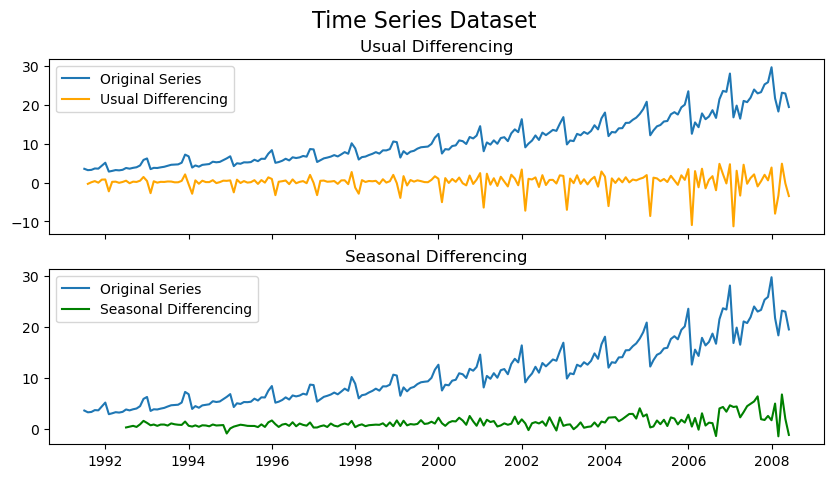

In [757]:
fig, axes = plt.subplots(2, 1, figsize=(10, 5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(data, label='Original Series')
axes[0].plot(data.diff(1), label='Usual Differencing', color='orange')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)

# Seasonal Differencing
axes[1].plot(data, label='Original Series')
axes[1].plot(data.diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
axes[1].legend(loc='upper left', fontsize=10)

plt.suptitle('Time Series Dataset', fontsize=16)
plt.show()

In [759]:
sarima_model = pm.auto_arima(data, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

sarima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=534.818, Time=0.92 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=624.061, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=596.068, Time=0.22 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=611.475, Time=0.23 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=757.274, Time=0.04 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=559.407, Time=0.24 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.16 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=536.817, Time=1.47 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=543.106, Time=0.59 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=537.592, Time=2.20 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=594.467, Time=0.15 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=529.829, Time=1.38 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=555.198, Time=0.22 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.27 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AI

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  204
Model:             SARIMAX(3, 0, 0)x(0, 1, [1], 12)   Log Likelihood                -258.394
Date:                              Fri, 20 Sep 2024   AIC                            528.788
Time:                                      18:18:07   BIC                            548.333
Sample:                                  07-01-1991   HQIC                           536.704
                                       - 06-01-2008                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1638      0.097      1.696      0.090      -0.026       0.353
ar.L1          0.0960      0.043      2.228      0.026       0.012       0.180
ar.L2          0.4148      0.035     11.922      0.000       0.347       0.483
ar.L3          0.3510      0.054      6.546      0.000       0.246       0.456
ma.S.L12      -0.4627      0.058     -7.966      0.000      -0.577      -0.349
sigma2         0.8470      0.057     14.914      0.000       0.736       0.958
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               124.39
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):              12.65   Skew:                             0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

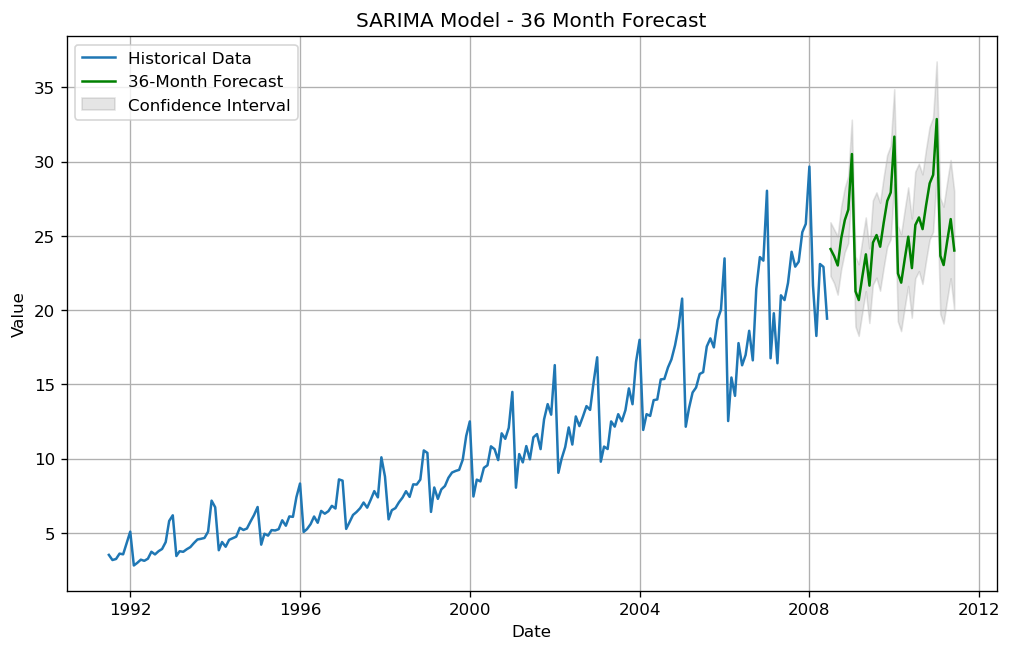

In [794]:
n_periods = 36
forecast, conf_int = sarima_model.predict(n_periods=n_periods, return_conf_int=True)

index_of_fc = pd.date_range(data.index[-1], periods=n_periods, freq='M')

forecast_df = pd.DataFrame(forecast)
conf_df = pd.DataFrame(conf_int, index=index_of_fc, columns=['Lower Bound', 'Upper Bound'])

plt.figure(figsize=(10, 6))

plt.plot(data, label='Historical Data')

# Plot the forecasted values
plt.plot(forecast_df, label='36-Month Forecast', color='green')

# Plot the confidence intervals
plt.fill_between(index_of_fc, conf_df['Lower Bound'], conf_df['Upper Bound'], 
                 color='k', alpha=0.1, label='Confidence Interval')

plt.title('SARIMA Model - 36 Month Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc='upper left', fontsize=10)
plt.grid(True)
plt.show()

### Interpretations:
nice forecast that captures the expected seasonal demand pattern.

## 10. SARIMAX model

(Seasonal AutoRegressive Integrated Moving Average with Exogenous Regressors)

SARIMAX is an extension of the SARIMA model that allows for the inclusion of exogenous variables (external predictors) in the model. These exogenous variables can help improve the forecasting performance by incorporating information from other related time series.

SARIMAX is highly useful when you have a seasonal time series and other variables that could impact the forecast (e.g., weather, economic indicators, or marketing campaigns).

In [839]:
from statsmodels.tsa.seasonal import seasonal_decompose

result_mul = seasonal_decompose(data['value'][-36:],   # 3 years
                                model='multiplicative', 
                                extrapolate_trend='freq')

seasonal_index = result_mul.seasonal[-12:].to_frame()
seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month

data['month'] = data.index.month
df = pd.merge(data, seasonal_index, how='left', on='month')
df.columns = ['value', 'month', 'seasonal_index']
df.index = data.index  # reassign the index

In [844]:
sxmodel = pm.auto_arima(df[['value']], exogenous=df[['seasonal_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=534.818, Time=1.78 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=624.061, Time=0.11 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=596.068, Time=0.57 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=611.475, Time=0.43 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=757.274, Time=0.10 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=559.407, Time=0.47 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=2.73 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=536.817, Time=3.29 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=543.106, Time=1.50 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=537.592, Time=4.67 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=594.467, Time=0.41 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=529.829, Time=2.10 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=555.198, Time=0.55 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=2.63 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AI

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  204
Model:             SARIMAX(3, 0, 0)x(0, 1, [1], 12)   Log Likelihood                -258.394
Date:                              Fri, 20 Sep 2024   AIC                            528.788
Time:                                      18:57:51   BIC                            548.333
Sample:                                  07-01-1991   HQIC                           536.704
                                       - 06-01-2008                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1638      0.097      1.696      0.090      -0.026       0.353
ar.L1          0.0960      0.043      2.228      0.026       0.012       0.180
ar.L2          0.4148      0.035     11.922      0.000       0.347       0.483
ar.L3          0.3510      0.054      6.546      0.000       0.246       0.456
ma.S.L12      -0.4627      0.058     -7.966      0.000      -0.577      -0.349
sigma2         0.8470      0.057     14.914      0.000       0.736       0.958
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               124.39
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):              12.65   Skew:                             0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

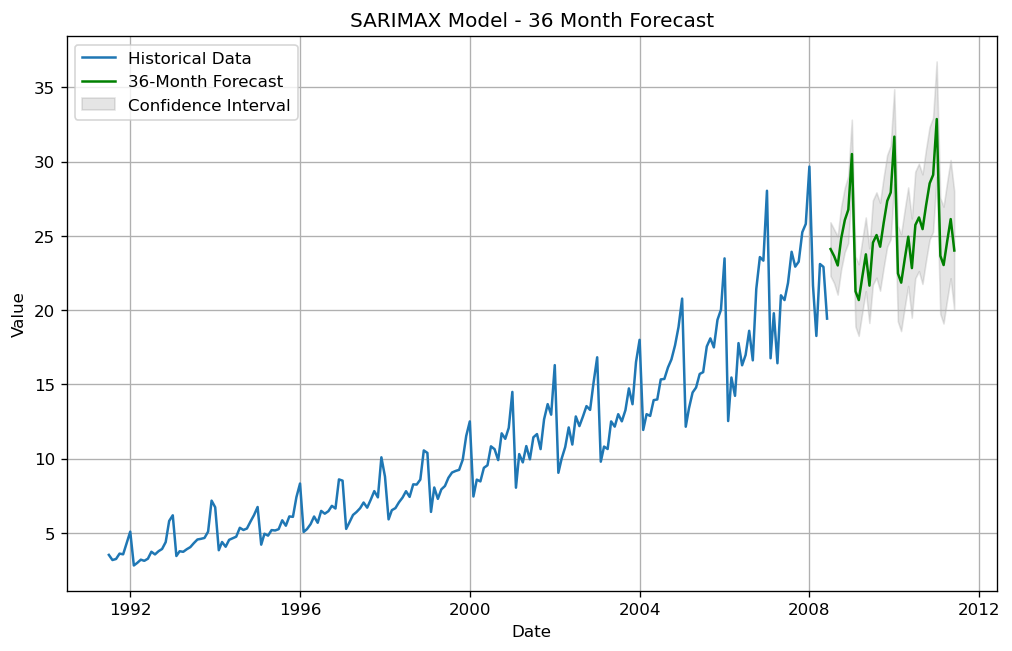

In [848]:
n_periods = 36
forecast, conf_int = sxmodel.predict(n_periods=n_periods, return_conf_int=True)

index_of_fc = pd.date_range(data.index[-1], periods=n_periods, freq='M')

forecast_df = pd.DataFrame(forecast)
conf_df = pd.DataFrame(conf_int, index=index_of_fc, columns=['Lower Bound', 'Upper Bound'])

plt.figure(figsize=(10, 6))

plt.plot(data.value, label='Historical Data')

# Plot the forecasted values
plt.plot(forecast_df, label='36-Month Forecast', color='green')

# Plot the confidence intervals
plt.fill_between(index_of_fc, conf_df['Lower Bound'], conf_df['Upper Bound'], 
                 color='k', alpha=0.1, label='Confidence Interval')

plt.title('SARIMAX Model - 36 Month Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc='upper left', fontsize=10)
plt.grid(True)
plt.show()